# Dump "Complementary filter"

Attitude estimation is determined from attitude propagation based on Gyro and measurements of tilt, roll and yaw
based on accelerometer and magnetometer, following [ahrs_python:doc](https://ahrs.readthedocs.io/en/latest/filters/complementary.html).

Basic idea is to combine attitude propagation (gyro, $\mathbf{q}_\mathrm{\omega}$) and attitude measurement
(magnetometer and accelormehter, $\mathbf{q}_\mathrm{am}$ with a complementary factor $\alpha$:

$
\mathbf{q} = (1 - \alpha) \mathbf{q}_\omega + \alpha\mathbf{q}_{am}, \quad \alpha \in (0, 1)
$

* yaw angle $\psi$: for North east down frame the angle between north and x axis in horizontal place
* pitch angle $\phi$: angle between horizontal plane and x axis
* roll angle $\theta$:

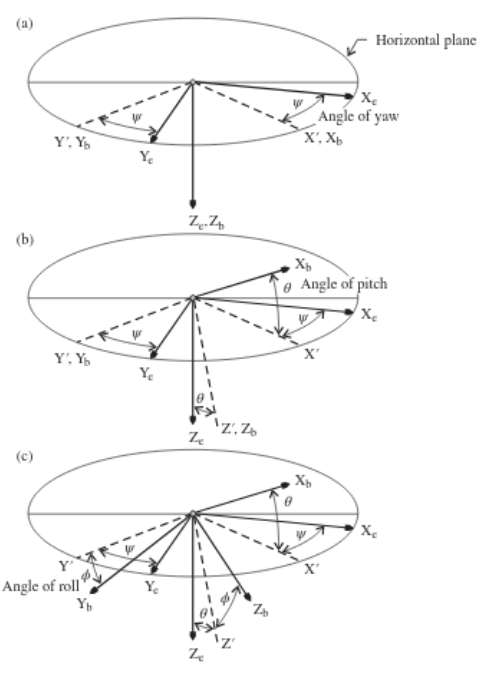

In [1]:
import sys
sys.path.append('../app/lib/build')

In [2]:
import numpy as np
import quaternionic as quat
from matplotlib import pyplot as plt

import pyahrs

In [3]:
def to_axis_angle(q):

    qw, qx, qy, qz = q
    angle = degrees(2 * acos(qw))
    s = sqrt(1 - qw ** 2)

    if (abs(s) < 1e-9):
        angle = 0.0
        x = 0.0
        y = 0.0
        z = 0.0
    else:
        x = qx / s
        y = qy / s
        z = qz / s
    return angle, x, y, z

In [6]:
data = np.loadtxt('test6.log')

In [7]:
def propagate_attitude(q, ω, Δt):
    q0 = q.to_scalar_part
    q1, q2, q3 = q.to_vector_part
    G = np.array([
        [-q1, q0, q3,-q2],
        [-q2,-q3, q0, q1],
        [-q3, q2,-q1, q0]
    ])
    
    return (q + quat.array(0.5 * G.T @ (ω * Δt))).normalized

In [17]:
Q = quat.array([[1.0, 0.0, 0.0, 0.0]] * (len(data) + 1))
Q_ = quat.array([[1.0, 0.0, 0.0, 0.0]] * (len(data) + 1))
Q__ = quat.array([[1.0, 0.0, 0.0, 0.0]] * (len(data) + 1))
Q2 = quat.array([[1.0, 0.0, 0.0, 0.0]] * (len(data) + 1))
last_t = None

for i, (qw, qx, qy, qz, ts, wx, wy, wz) in enumerate(data):
    if last_t is not None:
        dt = ts - last_t
        Q[i+1] = propagate_attitude(Q[i], 60*np.array((wx, wy, wz)), dt/1e3)
        Q2[i+1] = propagate_attitude(Q2[i], np.array((wx, wy, wz)), dt)
        Q_[i+1] = [qw, qx, qy, qz]
        Q__[i+1] = pyahrs.propagate_attitude(Q__[i,:], np.array((wx, wy, wz)), dt/1e3)
        
    last_t = ts

In [19]:
%matplotlib qt

fig, axs = plt.subplots(3, 1, sharex=True)

t, wx, wy, wz, *_ = data[:,4:].T

a, b, c = np.rad2deg(Q.to_axis_angle).T
plt.plot(t, a[1:], 'C0+-')
plt.plot(t, b[1:], 'C1+-')
plt.plot(t, c[1:], 'C2+-')


In [21]:
%matplotlib qt

fig, axs = plt.subplots(3, 1, sharex=True)

t, wx, wy, wz, *_ = data[:,4:].T

a, b, c = np.rad2deg(Q.to_axis_angle).T
plt.plot(t, a[1:], 'C0+-')
plt.plot(t, b[1:], 'C1+-')
#plt.plot(t, c[1:], 'C2+-')

a, b, c = np.rad2deg(Q_.to_axis_angle).T
plt.plot(t, a[1:], 'C1o--')
plt.plot(t, b[1:], 'C1+--')
plt.plot(t, c[1:], 'C2--')

In [21]:
%matplotlib qt

fig, axs = plt.subplots(3, 1, sharex=True)

t, wx, wy, wz, *_ = data[:,4:].T
axs[0].plot(t, 50*wx, 'C0+--')
axs[0].plot(t, 50*wy, 'C1+--')
axs[0].plot(t, 50*wz, 'C2+--')

a, b, c = np.rad2deg(Q.to_axis_angle).T
axs[1].plot(t, a[1:], 'C0+-')
axs[1].plot(t, b[1:], 'C1+-')
axs[1].plot(t, c[1:], 'C2+-')

a, b, c = np.rad2deg(Q_.to_axis_angle).T
axs[2].plot(t, a[1:], 'C0+-')
axs[2].plot(t, b[1:], 'C1+-')
axs[2].plot(t, c[1:], 'C2+-')